In [3]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(image_dir))
        self.annotation_files = sorted(os.listdir(annotation_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        annot_path = os.path.join(self.annotation_dir, self.annotation_files[idx])

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_annotation(annot_path)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_annotation(self, annot_path):
        tree = ET.parse(annot_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class detection for simplicity

        return boxes, labels


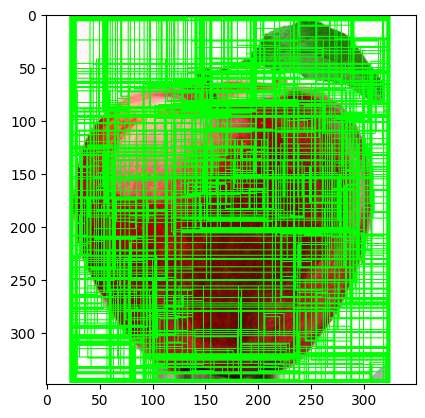

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(image_dir="../dataset/train_zip/train",
                              annotation_dir="../dataset/train_zip/train",
                              transforms=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [6]:
def get_iou(bb1, bb2) :
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # 두개의 박스 영역을 계산합니다.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    # 오버랩이 출력이 없거나, 영역이 없는 경우
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # 오버랩된 영역의 넓이를 계산합니다.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # 각 박스의 영역을 계산합니다.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # union area = area_a + area_b - intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

'''
get_iou 함수에 대해 설명
- 두 개의 bounding box 정보를 입력으로 받아서 두 bounding box의 IoU를 계산하는 함수
- 각 bounding box는 x1, y1, x2, y2의 좌표 정보를 가지고 있음
- 두 bounding box의 IoU를 계산하는 공식은 아래와 같음
- IoU = intersection_area / (area_a + area_b - intersection_area)
- intersection_area는 두 bounding box의 교집합 영역의 넓이
- area_a는 첫 번째 bounding box의 넓이
- area_b는 두 번째 bounding box의 넓이
- bounding box의 좌표 정보를 이용하여 두 bounding box의 교집합 영역의 넓이를 계산
- 두 bounding box의 넓이를 이용하여 IoU를 계산
- IoU는 0과 1 사이의 값을 가지며, 1에 가까울수록 두 bounding box가 유사한 위치에 있음을 의미
'''


'\nget_iou 함수에 대해 설명\n- 두 개의 bounding box 정보를 입력으로 받아서 두 bounding box의 IoU를 계산하는 함수\n- 각 bounding box는 x1, y1, x2, y2의 좌표 정보를 가지고 있음\n- 두 bounding box의 IoU를 계산하는 공식은 아래와 같음\n- IoU = intersection_area / (area_a + area_b - intersection_area)\n- intersection_area는 두 bounding box의 교집합 영역의 넓이\n- area_a는 첫 번째 bounding box의 넓이\n- area_b는 두 번째 bounding box의 넓이\n- bounding box의 좌표 정보를 이용하여 두 bounding box의 교집합 영역의 넓이를 계산\n- 두 bounding box의 넓이를 이용하여 IoU를 계산\n- IoU는 0과 1 사이의 값을 가지며, 1에 가까울수록 두 bounding box가 유사한 위치에 있음을 의미\n'

In [7]:
# 데이터셋 리스트 생성
train_images = []
train_labels = []

In [8]:
for batch in train_loader:
    images, img_names, labels = batch
    for img_tensor, img_name, label in zip(images, img_names, labels):
        try:
            img = img_tensor.numpy().transpose((1, 2, 0))  # Tensor를 numpy 배열로 변환
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # OpenCV 형식에 맞게 색상 채널 변환
            
            # xml 파일 경로
            annotation_path = os.path.join('../../dataset/train_zip/train/', img_name.replace('.jpg', '.xml'))
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            gtvalues = []
            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                x1 = int(bbox.find('xmin').text)
                y1 = int(bbox.find('ymin').text)
                x2 = int(bbox.find('xmax').text)
                y2 = int(bbox.find('ymax').text)
                gtvalues.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})

            selective_search.setBaseImage(img)
            selective_search.switchToSelectiveSearchFast()
            ssresults = selective_search.process()
            imout = img.copy()
            counter = 0
            falsecounter = 0

            for e, result in enumerate(ssresults):
                if e < 2000:
                    for gtval in gtvalues:
                        x, y, w, h = result
                        iou = get_iou(gtval, {"x1": x, "x2": x+w, "y1": y, "y2": y+h})
                        if counter < 30 and iou > 0.70:
                            timage = imout[y:y+h, x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                        elif falsecounter < 30 and iou < 0.3:
                            fimage = imout[y:y+h, x:x+w]
                            resized = cv2.resize(fimage, (224, 224), interpolation=cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
        except Exception as e:
            print(e)
            print(f"error in processing image or label: {img_name}")
            continue

print(f"train_images: {len(train_images)}")

c:\Users\royal\anaconda3\envs\base_jyp\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_images: 7318


In [9]:
x_train = np.array(train_images)
y_train = np.array(train_labels)

In [10]:
# 모델 정의
model = models.vgg16(pretrained=True)
model.classifier[3] = nn.Linear(4096, 3)
model = model.cuda()
model.train()

c:\Users\royal\anaconda3\envs\base_jyp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\royal\anaconda3\envs\base_jyp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
svm_image = []
svm_label = []

In [42]:
for batch in train_loader:
    images, img_names, labels = batch
    for img_tensor, img_name, label in zip(images, img_names, labels):
        try:
            img = img_tensor.numpy().transpose((1, 2, 0))  # Tensor를 numpy 배열로 변환
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # OpenCV 형식에 맞게 색상 채널 변환
            
            # xml 파일 경로
            annotation_path = os.path.join('../../dataset/train_zip/train/', img_name.replace('.jpg', '.xml'))
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            gtvalues = []
            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                x1 = int(bbox.find('xmin').text)
                y1 = int(bbox.find('ymin').text)
                x2 = int(bbox.find('xmax').text)
                y2 = int(bbox.find('ymax').text)
                gtvalues.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})

            selective_search.setBaseImage(img)
            selective_search.switchToSelectiveSearchFast()
            ssresults = selective_search.process()
            imout = img.copy()
            counter = 0
            falsecounter = 0

            for e, result in enumerate(ssresults):
                if e < 2000:
                    for gtval in gtvalues:
                        x, y, w, h = result
                        iou = get_iou(gtval, {"x1": x, "x2": x+w, "y1": y, "y2": y+h})
                        if counter < 30 and iou > 0.70:
                            timage = imout[y:y+h, x:x+w]
                            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                            svm_image.append(resized)
                            svm_label.append(1)
                            counter += 1
                        elif falsecounter < 30 and iou < 0.3:
                            fimage = imout[y:y+h, x:x+w]
                            resized = cv2.resize(fimage, (224, 224), interpolation=cv2.INTER_AREA)
                            svm_image.append(resized)
                            svm_label.append(0)
                            falsecounter += 1
        except Exception as e:
            print(e)
            print(f"error in processing image or label: {img_name}")
            continue

print(f"train_images: {len(train_images)}")

c:\Users\royal\anaconda3\envs\base_jyp\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train_images: 7318


In [43]:
# SVM 학습을 위한 데이터셋 생성
x_svm = np.array(svm_image)
y_svm = np.array(svm_label)

# SVM 모델 학습
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_svm = x_svm.reshape(x_svm.shape[0], -1)
x_train = x_train.reshape(x_train.shape[0], -1)

x_train, x_val, y_train, y_val = train_test_split(x_svm, y_svm, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)

SVC(kernel='linear')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


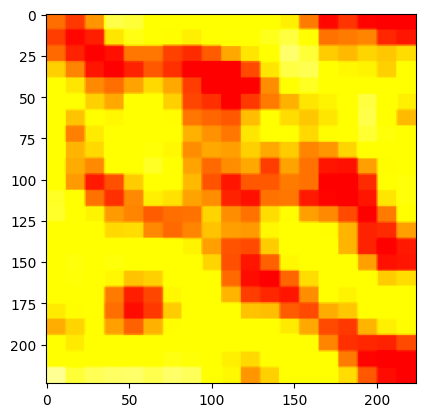

In [44]:
# plt 출력
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

In [45]:
# SVM 모델 평가
y_pred = clf.predict(x_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred)}")

Accuracy: 0.9931693989071039


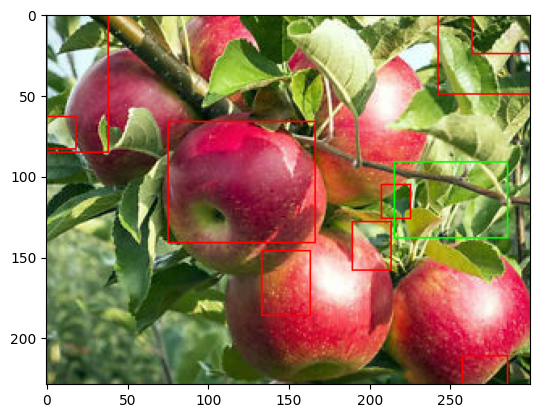

In [37]:
image_path = '../../dataset/test_zip/test/apple_77.jpg'
image = cv2.imread(image_path)

if image is None:
    print(f"이미지를 읽어오지 못했습니다. 경로를 확인하세요: {image_path}")
else:
    selective_search.setBaseImage(image)
    selective_search.switchToSelectiveSearchFast()
    rects = selective_search.process()
    out = image.copy()
    for i, rect in enumerate(rects):
        if i < 10:
            x, y, w, h = rect
            roi = image[y:y+h, x:x+w]
            resized = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
            resized = resized.reshape(1, -1)
            pred = clf.predict(resized)
            if pred == 1:
                cv2.rectangle(out, (x, y), (x+w, y+h), (0, 255, 0), 1)
            else:
                cv2.rectangle(out, (x, y), (x+w, y+h), (0, 0, 255), 1)


plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))